In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import time

# Set a nice style for the plots
sns.set_theme(style="whitegrid")
print("Libraries imported successfully.")

import os

def get_figures_path():
    target_suffix = os.path.join("Contrastive_Learning", "code", "ML_model", "figures")
    cwd = os.path.abspath(os.getcwd())
    parts = cwd.split(os.sep)
    for i in range(len(parts), 0, -1):
        candidate = os.sep.join(parts[:i])
        test_path = os.path.join(candidate, target_suffix)
        if os.path.isdir(test_path):
            return test_path
    raise FileNotFoundError(f"Path ending with '{target_suffix}' not found")


Libraries imported successfully.


In [2]:


def load_single_run_results(results_folder: str, run_name: str=None) -> pd.DataFrame:
    """Loads the Spearman correlation results for a single, specified run."""

    if run_name:
        filepath = Path(results_folder) / run_name / "tsplice_spearman_by_tissue.tsv"
    else:
        filepath = Path(results_folder) / "tsplice_spearman_by_tissue.tsv"
    print(f"Loading single run results from: {filepath}")
    
    # Load the tab-separated file
    df = pd.read_csv(filepath, sep='\t')
    
    # --- ADDED THIS STEP ---
    # Standardize column names to match the expected format ('spearman_rho_...')
    # This handles files that might have the older 'spearman_psi' naming.
    rename_dict = {
        'spearman_psi': 'spearman_rho_psi',
        'spearman_delta': 'spearman_rho_delta_psi'
    }
    df.rename(columns=rename_dict, inplace=True)
    
    return df


print("Data loading functions defined.")

Data loading functions defined.


In [3]:
def _prepare_single_model_df(df, metric, model_name):
    """Internal helper to prepare one DataFrame for comparison."""
    is_averaged = f'mean_{metric}' in df.columns
    metric_col = f'mean_{metric}' if is_averaged else metric
    std_col = f'std_{metric}' if is_averaged else None

    cols_to_select = ['tissue', metric_col]
    if is_averaged and std_col and std_col in df.columns:
        cols_to_select.append(std_col)
    
    plot_df = df[cols_to_select].copy()
    plot_df.rename(columns={metric_col: model_name}, inplace=True)
    return plot_df

def prepare_grouped_plot_data(df1, df2, metric, model1_name, model2_name):
    """
    Prepares and merges data from two models for a grouped bar plot.

    Args:
        df1 (pd.DataFrame): DataFrame for the first model.
        df2 (pd.DataFrame): DataFrame for the second model.
        metric (str): The base metric name (e.g., 'spearman_rho_psi').
        model1_name (str): Custom name for the first model.
        model2_name (str): Custom name for the second model.

    Returns:
        tuple[pd.DataFrame, pd.DataFrame]: A tuple containing:
            - comparison_df: The merged, wide-format DataFrame.
            - melted_df: The long-format DataFrame ready for seaborn.
    """
    model1_plot_df = _prepare_single_model_df(df1, metric, model1_name)
    model2_plot_df = _prepare_single_model_df(df2, metric, model2_name)

    # Merge the two prepared dataframes
    comparison_df = pd.merge(model1_plot_df, model2_plot_df, on='tissue', how='inner')
    
    # "Melt" the dataframe for seaborn plotting
    melted_df = comparison_df.melt(id_vars='tissue', value_vars=[model1_name, model2_name], 
                                   var_name='Model', value_name='Spearman ρ')
    
    return comparison_df, melted_df

In [4]:
def plot_grouped_comparison(comparison_df, melted_df, title, model1_name, model2_name, save_path=None):
    """
    Generates a grouped bar plot from prepared dataframes.

    Args:
        comparison_df (pd.DataFrame): The merged, wide-format DataFrame.
        melted_df (pd.DataFrame): The long-format DataFrame for plotting.
        title (str): The title for the plot.
        model1_name (str): Name of the first model.
        model2_name (str): Name of the second model.
        save_path (str, optional): Path to save the figure.
    """
    plt.figure(figsize=(16, 8))
    ax = sns.barplot(data=melted_df, x='tissue', y='Spearman ρ', hue='Model', 
                     palette={model1_name: 'lightgray', model2_name: 'mediumseagreen'})
    
    # Add error bars if standard deviation data exists for the second model
    std_col = [col for col in comparison_df.columns if col.startswith('std_')]
    if std_col:
        error_map = comparison_df.set_index('tissue')[std_col[0]].to_dict()
        patches = [p for p in ax.patches if p.get_height() > 0]
        model2_bars = patches[len(patches)//2:] # Second model's bars are the second half
        
        for i, bar in enumerate(model2_bars):
            tissue_name = ax.get_xticklabels()[i].get_text()
            error = error_map.get(tissue_name)
            if pd.notna(error):
                ax.errorbar(x=bar.get_x() + bar.get_width() / 2, y=bar.get_height(), yerr=error,
                            fmt='none', capsize=5, color='black')

    plt.title(title, fontsize=18)
    plt.ylabel('Spearman ρ', fontsize=12)
    plt.xlabel('Tissue', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Model')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")

    plt.show()

def plot_average_across_tissues_2models(
    df1, df2, model1_name, model2_name,
    metric, save_path=None
):
    """
    Compute and plot the average metric across all tissues for 2 models.
    Each dataframe must contain 'tissue' and the target metric column.

    Args:
        df1, df2, df3: DataFrames containing per-tissue metric values.
        model1_name, model2_name, model3_name: Model labels for legend.
        metric: str, metric column name (e.g. 'spearman_rho_psi').
        save_path: Optional path to save the figure.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd

    # Compute averages
    avg_df = pd.DataFrame({
        'Model': [model1_name, model2_name],
        'Average': [
            df1[metric].mean(),
            df2[metric].mean()
        ]
    })

    # Determine dynamic y-axis range
    y_min = max(0, avg_df["Average"].min() - 0.05)
    y_max = min(1.0, avg_df["Average"].max() + 0.1)

    # Plot
    plt.figure(figsize=(6, 5))
    sns.barplot(data=avg_df, x='Model', y='Average', palette='viridis')

    plt.ylabel(f"Average {metric.replace('_', ' ').title()}")
    plt.title(f"Average {metric.replace('_', ' ').title()} Across All Tissues")
    plt.ylim(y_min, y_max)
    plt.xticks(rotation=25, ha='right')
    plt.tight_layout()

    # Save and show
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"✅ Saved average plot: {save_path}")

    plt.show()
    return avg_df

In [ ]:
################ 2 user inputs WITH SOTA ################

In [10]:
# --- Assuming imports and previous helper functions are defined ---
# Make sure load_sota_results, load_single_run_results, load_and_average_all_runs are available

# --- Configuration ---
# --- Folder 1 ---
result_file_name1 =  "exprmnt_2025_11_03__16_02_02" # EMPRAIPsi_TblaSpns_noCL_do0.4_300bp_2025_11_03__16_02_02
model1_user_name_norun = 'TblaSpns_noCL_do0.4_300bp'
model1_user_name = f'{model1_user_name_norun}_ensembled'
model1_user_avg_name = f'{model1_user_name_norun}_avg'
model1_runNumber = None


# --- Folder 2 (Define paths and names for your second experiment) ---
result_file_name2 =  "exprmnt_2025_11_03__16_11_50" # EMPRAIPsi_TblaSpns_noCL_do0.1_300bp_2025_11_03__16_11_50
model2_user_name_norun = 'TblaSpns_noCL_do0.1_300bp'
model2_user_name = f'{model2_user_name_norun}_ensembled'
model2_user_avg_name = f'{model2_user_name_norun}_avg'
model2_runNumber = None

In [11]:
# --- Base Dirs ---
# main_dir = "/gpfs/commons/home/atalukder/Contrastive_Learning/files/results/"
main_dir = "/mnt/home/at3836/Contrastive_Learning/files/results/"
fig_maindir = get_figures_path()
trimester = time.strftime("_%Y_%m_%d__%H_%M_%S")

# --- Full Paths ---
RESULTS_FOLDER_PATH1 = f"{main_dir}/{result_file_name1}/ensemble_evaluation_from_valdiation/test_set_evaluation" # <<< Path for Folder 1
RESULTS_FOLDER_PATH2 = f"{main_dir}/{result_file_name2}/ensemble_evaluation_from_valdiation/test_set_evaluation" # <<< Path for Folder 2

In [12]:
# --- Load Data ---
print("--- Loading Data ---")
try:
    
    single_run_1_results = load_single_run_results(RESULTS_FOLDER_PATH1)
    # averaged_run_1_results = load_and_average_all_runs(RESULTS_FOLDER_PATH1)
    print(f"Loaded Folder 1: {result_file_name1}")

    # Results for Folder 2 (Single Run & Averaged)
    single_run_2_results = load_single_run_results(RESULTS_FOLDER_PATH2)
    # averaged_run_2_results = load_and_average_all_runs(RESULTS_FOLDER_PATH2)
    print(f"Loaded Folder 2: {result_file_name2}")

except FileNotFoundError as e:
    print(f"Error loading files: {e}")
    exit()
except Exception as e:
    print(f"An unexpected error occurred during loading: {e}")
    exit()

--- Loading Data ---
Loading single run results from: /mnt/home/at3836/Contrastive_Learning/files/results/exprmnt_2025_11_03__16_02_02/ensemble_evaluation_from_valdiation/test_set_evaluation/tsplice_spearman_by_tissue.tsv
Loaded Folder 1: exprmnt_2025_11_03__16_02_02
Loading single run results from: /mnt/home/at3836/Contrastive_Learning/files/results/exprmnt_2025_11_03__16_11_50/ensemble_evaluation_from_valdiation/test_set_evaluation/tsplice_spearman_by_tissue.tsv
Loaded Folder 2: exprmnt_2025_11_03__16_11_50


In [ ]:
################ 2 user inputs ################

Figure saved to: /mnt/home/at3836/Contrastive_Learning/code/ML_model/figures/spearman_rho_psi_TblaSpns_noCL_do0.4_300bp_ensembled_vs_TblaSpns_noCL_do0.1_300bp_ensembled_2025_11_03__17_57_13.png


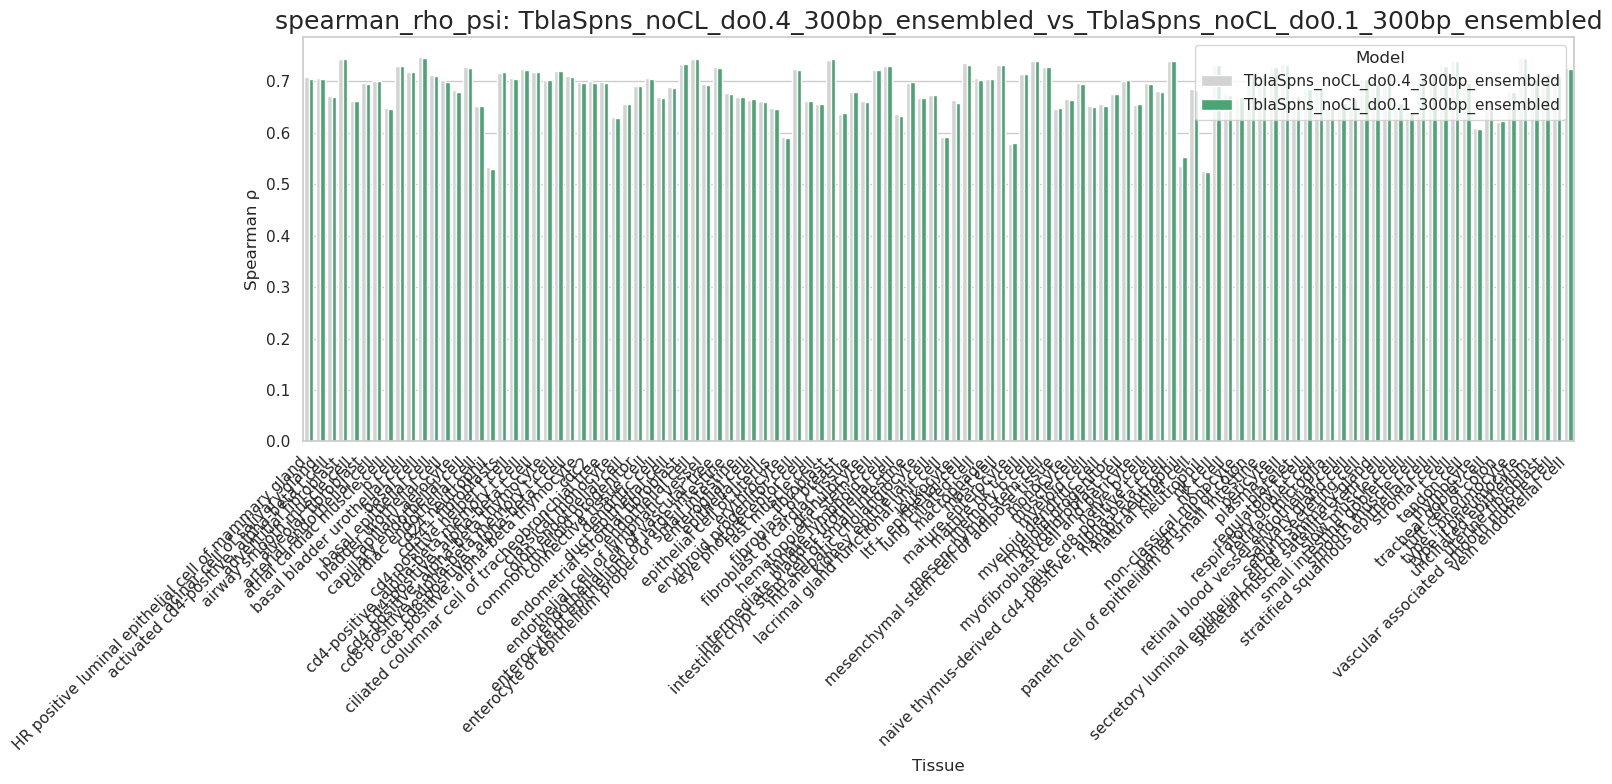

Figure saved to: /mnt/home/at3836/Contrastive_Learning/code/ML_model/figures/spearman_rho_delta_psi_TblaSpns_noCL_do0.4_300bp_ensembled_vs_TblaSpns_noCL_do0.1_300bp_ensembled_2025_11_03__17_57_13.png


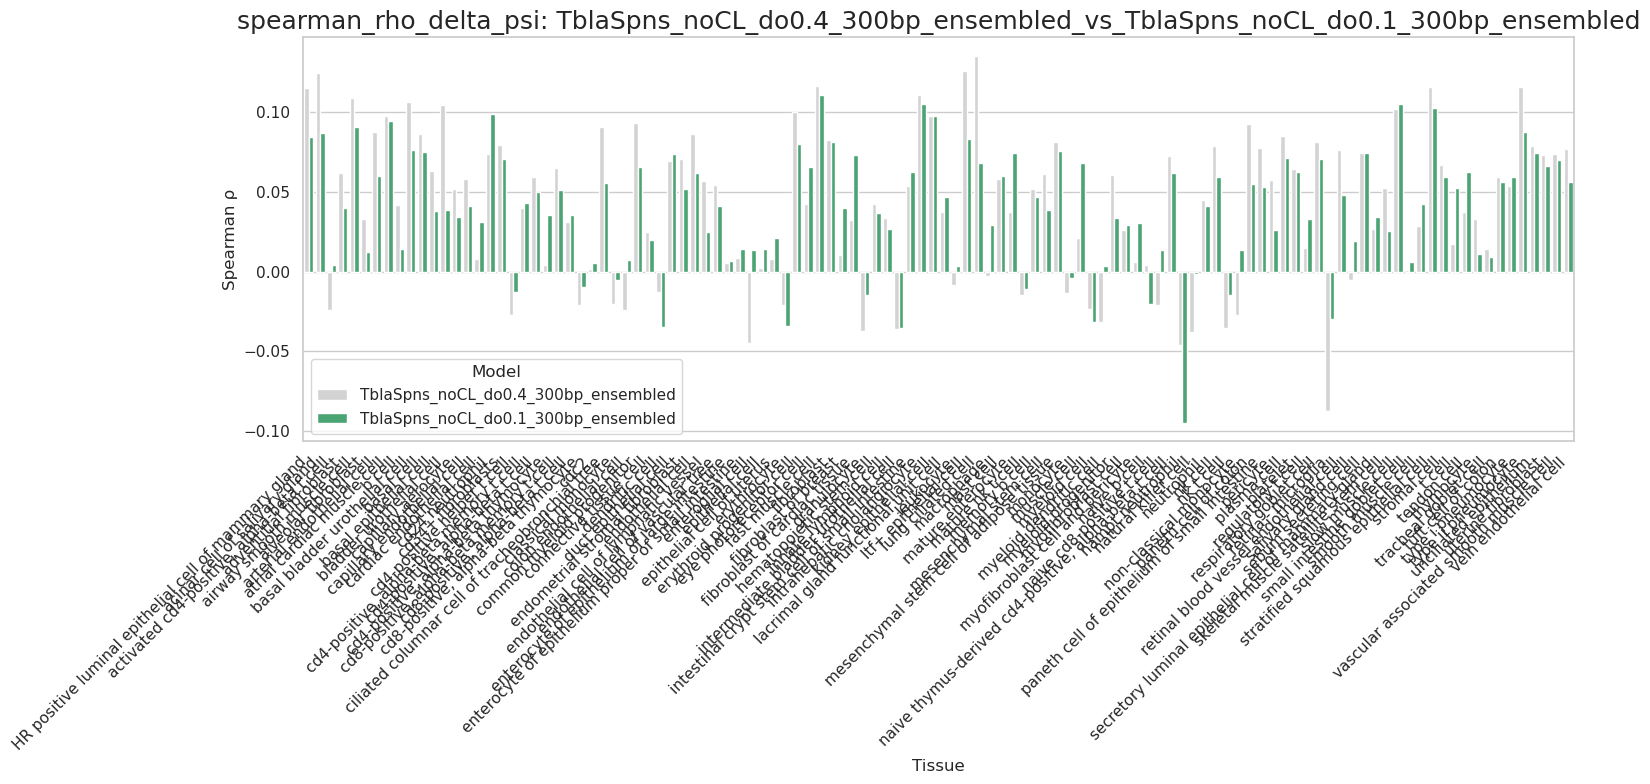

In [13]:
# Prepare the data
# Prepare the data SINGLE RUN 1 vs SINGLE RUN 2

title_single = f"{model1_user_name}_vs_{model2_user_name}"
metric_psi = 'spearman_rho_psi'
metric_delta = 'spearman_rho_delta_psi'

import time
trimester = time.strftime("_%Y_%m_%d__%H_%M_%S")
fig_maindir = get_figures_path()

comp_df_1, melt_df_1 = prepare_grouped_plot_data(
    df1=single_run_1_results,
    df2=single_run_2_results,
    metric=metric_psi,
    model1_name=model1_user_name,
    model2_name=model2_user_name
)

# Create the plot
plot_grouped_comparison(
    comp_df_1, melt_df_1,
    title=f'{metric_psi}: {title_single}',
    model1_name=model1_user_name,
    model2_name=model2_user_name,
    save_path=f"{fig_maindir}/spearman_rho_psi_{title_single}{trimester}.png"
)

# Prepare the data
comp_df_1, melt_df_1 = prepare_grouped_plot_data(
    df1=single_run_1_results,
    df2=single_run_2_results,
    metric=metric_delta,
    model1_name=model1_user_name,
    model2_name=model2_user_name
)

# Create the plot
plot_grouped_comparison(
    comp_df_1, melt_df_1,
    title=f'{metric_delta}: {title_single}',
    model1_name=model1_user_name,
    model2_name=model2_user_name,
    save_path=f"{fig_maindir}/spearman_rho_delta_psi_{title_single}{trimester}.png"
)






--- Plotting Average Spearman Correlations Across All Tissues ---


/tmp/ipykernel_2123338/43660751.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_df, x='Model', y='Average', palette='viridis')


✅ Saved average plot: /mnt/home/at3836/Contrastive_Learning/code/ML_model/figures/avg_spearman_rho_psi_TblaSpns_noCL_do0.4_300bp_ensembled_vs_TblaSpns_noCL_do0.1_300bp_ensembled_2025_11_03__17_57_13.png


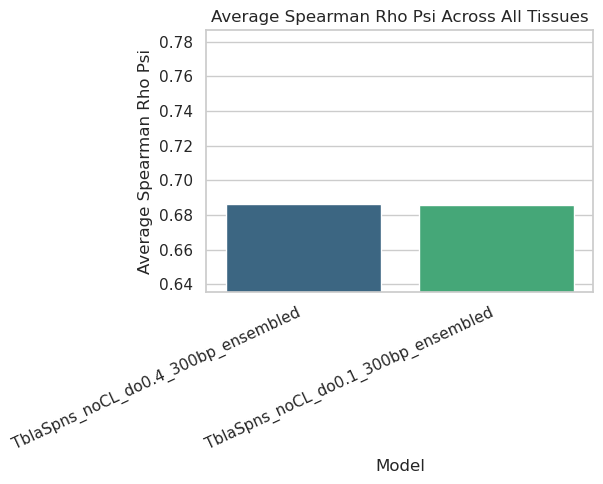

/tmp/ipykernel_2123338/43660751.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_df, x='Model', y='Average', palette='viridis')


✅ Saved average plot: /mnt/home/at3836/Contrastive_Learning/code/ML_model/figures/avg_spearman_rho_delta_psi_TblaSpns_noCL_do0.4_300bp_ensembled_vs_TblaSpns_noCL_do0.1_300bp_ensembled_2025_11_03__17_57_13.png


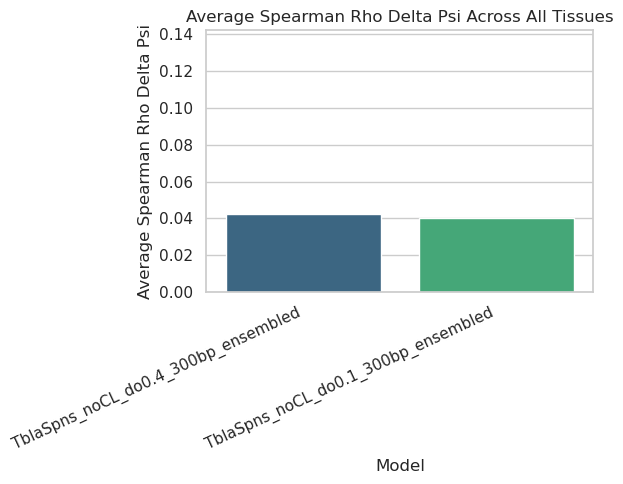


--- Average Summary ---
                                 Model   Average
0  TblaSpns_noCL_do0.4_300bp_ensembled  0.686484
1  TblaSpns_noCL_do0.1_300bp_ensembled  0.685593
                                 Model   Average
0  TblaSpns_noCL_do0.4_300bp_ensembled  0.042207
1  TblaSpns_noCL_do0.1_300bp_ensembled  0.040064


In [14]:
print("\n--- Plotting Average Spearman Correlations Across All Tissues ---")

avg_psi = plot_average_across_tissues_2models(
   single_run_1_results, single_run_2_results,
model1_user_name, model2_user_name,
    metric='spearman_rho_psi',
    save_path=f"{fig_maindir}/avg_{metric_psi}_{title_single}{trimester}.png"
)

avg_delta = plot_average_across_tissues_2models(
    single_run_1_results, single_run_2_results,
    model1_user_name, model2_user_name,
    metric='spearman_rho_delta_psi',
    save_path=f"{fig_maindir}/avg_{metric_delta}_{title_single}{trimester}.png"
)

print("\n--- Average Summary ---")
print(avg_psi)
print(avg_delta)


In [ ]:
######################################